In [50]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [51]:
import warnings
warnings.filterwarnings("ignore")

In [52]:
final_SNPs = pd.read_hdf('data/BeanCAP_MDP_genotype_data.hdf5', 'snptable')
pheno_all = pd.read_csv('data/Adjusted-means-for-Agronomic-traits-with-race-and-market-calss-info.txt',
                       sep = '\t', header=0)
pheno_all.head()

,supop,market_class,taxa,df_co,dm_co,ch_co,lg_co,gh_co,sw_co,df_mi,...,dm_ne,ch_ne,lg_ne,sw_ne,df,dm,ch,lg,gh,sw
0,MA,black,115m,49,92,50,4,2,20.0,41,...,96,41,4,20.5,49,102,45,3.67,2.5,21.5
1,DJ,pink,6r_42,46,90,41,5,3,29.9,38,...,101,40,5,30.5,47,103,37,5.00,3.0,32.3
2,MA,black,92bg_7,49,87,48,3,3,22.8,44,...,79,33,2,21.7,50,92,39,2.33,2.5,21.7
3,DJ,pinto,92us_1006,46,82,45,1,2,30.3,38,...,78,45,1,29.2,45,90,43,1.33,2.0,31.3
4,MA,cream_caroca,a_285,51,94,55,3,3,22.2,45,...,95,40,3,20.9,52,103,48,3.00,2.5,23.1


In [53]:
from model_prescreen import classification_task_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import make_scorer, precision_score, confusion_matrix, classification_report

sns.set(font_scale=2)
sns.set_style("whitegrid")

## Prepare selector functions

In [54]:
def report_res(estimator, X_train, y_train, average):
    y_pred = cross_val_predict(estimator, X_train,
                                 y_train, groups=y_train,
                                 cv = 5, n_jobs=6)
    print(precision_score(y_train, y_pred, average=average))
    print(classification_report(y_train, y_pred))
    return(y_pred)


def feature_selector(X,y, k=2000):
    selector = SelectKBest(f_classif, k=k)
    selector.fit(X,y)
    return selector

## Prepare models

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

# GBC model

gbc = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=0.29522198720269971, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=28, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=76,
              presort='auto', random_state=42, subsample=0.8, verbose=0,
              warm_start=False)

# Ensemble

clf1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=36, max_features=0.46466020103939104,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=59, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)
clf2 = LogisticRegression(C=0.0019010245319870352, class_weight='balanced',
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=42, solver='liblinear', tol=0.045627721822084709,
          verbose=0, warm_start=False)
clf3 = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=0.29522198720269971, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=28, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=76,
              presort='auto', random_state=42, subsample=0.8, verbose=0,
              warm_start=False)

eclf = VotingClassifier(estimators=[('rf',clf1),('logit', clf2), ('gbc', clf3)], voting='soft')

In [56]:
# infos 'df_co', 'df_mi','df_ne', 'df_nd'
# For calculating confutions matrics of all the things togethers
all_preds=[]
all_y=[]

## Colorado

In [57]:
df = pheno_all['df_co']
df_classes = pd.qcut(df, q=[0,.25, .75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101*1)

selector = feature_selector(X_train, y_train)
X_train_s  = selector.transform(X_train)
print(X_train_s.shape)

X_test_s = selector.transform(X_test)

gbc_co = gbc
eclf_co = eclf

(224, 2000)


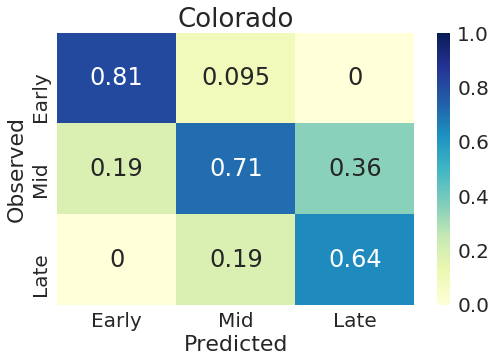

Precision : 0.722222222222
Classification 
             precision    recall  f1-score   support

          0       0.81      0.89      0.85        19
          1       0.71      0.62      0.67        24
          2       0.64      0.69      0.67        13

avg / total       0.73      0.73      0.73        56



In [58]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
eclf_co.fit(X_train_s, y_train)
pred = eclf_co.predict(X_test_s)
all_preds.append(pred)
all_y.append(y_test)
conf_matrix = confusion_matrix(y_test, pred)
# try different plots of the confusion matrix
norm_matrix = conf_matrix/conf_matrix.sum(axis=0, keepdims=True)
plt.figure(figsize=(8,5))
sns.heatmap(norm_matrix, annot=True, 
            xticklabels=['Early', 'Mid', 'Late'],
           yticklabels = ['Early', 'Mid', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('Colorado', fontsize=26)
plt.show()
print('Precision :', precision_score(y_test, pred, average = 'macro'))
print('Classification ' + '\n'+ classification_report(y_test, pred))

## Michigan

In [59]:
df = pheno_all['df_mi']
df_classes = pd.qcut(df, q=[0,.25, .75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101*2)

selector = feature_selector(X_train, y_train)
X_train_s  = selector.transform(X_train)
print(X_train_s.shape)

X_test_s = selector.transform(X_test)

gbc_mi = gbc
eclf_mi = eclf

(224, 2000)


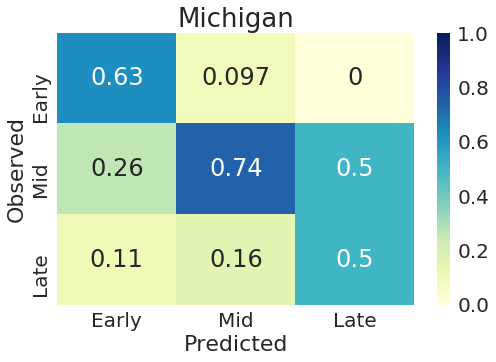

Precision : 0.624504810413
Classification 
             precision    recall  f1-score   support

          0       0.63      0.80      0.71        15
          1       0.74      0.74      0.74        31
          2       0.50      0.30      0.37        10

avg / total       0.67      0.68      0.67        56



In [60]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
eclf_mi.fit(X_train_s, y_train)
pred = eclf_mi.predict(X_test_s)
all_preds.append(pred)
all_y.append(y_test)
conf_matrix = confusion_matrix(y_test, pred)
# try different plots of the confusion matrix
norm_matrix = conf_matrix/conf_matrix.sum(axis=0, keepdims=True)
plt.figure(figsize=(8,5))
sns.heatmap(norm_matrix, annot=True, 
            xticklabels=['Early', 'Mid', 'Late'],
           yticklabels = ['Early', 'Mid', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('Michigan', fontsize=26)
plt.show()
print('Precision :', precision_score(y_test, pred, average = 'macro'))
print('Classification ' + '\n'+ classification_report(y_test, pred))

## Nebraska

In [61]:
df = pheno_all['df_ne']
df_classes = pd.qcut(df, q=[0,.25, .75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101*3)

selector = feature_selector(X_train, y_train)
X_train_s  = selector.transform(X_train)
print(X_train_s.shape)

X_test_s = selector.transform(X_test)

gbc_ne = gbc
eclf_ne = eclf

(224, 2000)


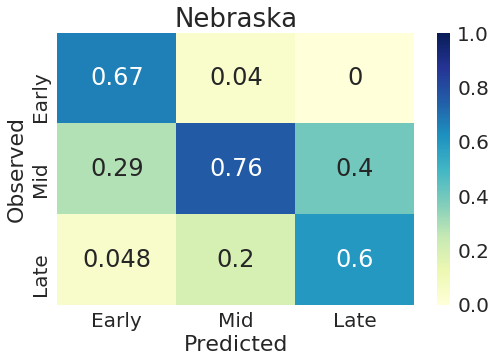

Precision : 0.675555555556
Classification 
             precision    recall  f1-score   support

          0       0.67      0.93      0.78        15
          1       0.76      0.66      0.70        29
          2       0.60      0.50      0.55        12

avg / total       0.70      0.70      0.69        56



In [62]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
eclf_ne.fit(X_train_s, y_train)
pred = eclf_ne.predict(X_test_s)
all_preds.append(pred)
all_y.append(y_test)
conf_matrix = confusion_matrix(y_test, pred)
# try different plots of the confusion matrix
norm_matrix = conf_matrix/conf_matrix.sum(axis=0, keepdims=True)
plt.figure(figsize=(8,5))
sns.heatmap(norm_matrix, annot=True, 
            xticklabels=['Early', 'Mid', 'Late'],
           yticklabels = ['Early', 'Mid', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('Nebraska', fontsize=26)
plt.show()
print('Precision :', precision_score(y_test, pred, average = 'macro'))
print('Classification ' + '\n'+ classification_report(y_test, pred))

## NOrth Dakot

In [63]:
df = pheno_all['df_nd']
df_classes = pd.qcut(df, q=[0,.25, .75, 1], labels = False)

y = df_classes.values
X = final_SNPs.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   stratify = y,
                                                   random_state = 101*4)

selector = feature_selector(X_train, y_train)
X_train_s  = selector.transform(X_train)
print(X_train_s.shape)

X_test_s = selector.transform(X_test)

gbc_nd = gbc
eclf_nd = eclf

(224, 2000)


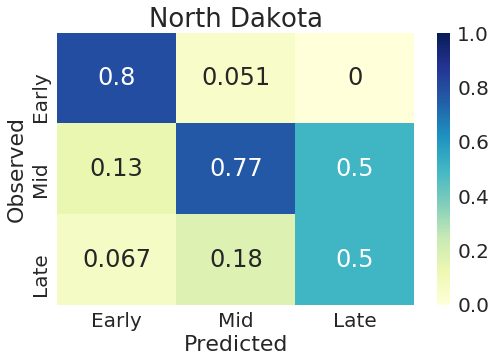

Precision : 0.689743589744
Classification 
             precision    recall  f1-score   support

          0       0.80      0.86      0.83        14
          1       0.77      0.91      0.83        33
          2       0.50      0.11      0.18         9

avg / total       0.73      0.77      0.73        56



In [64]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
eclf_nd.fit(X_train_s, y_train)
pred = eclf_nd.predict(X_test_s)
all_preds.append(pred)
all_y.append(y_test)
conf_matrix = confusion_matrix(y_test, pred)
# try different plots of the confusion matrix
norm_matrix = conf_matrix/conf_matrix.sum(axis=0, keepdims=True)
plt.figure(figsize=(8,5))
sns.heatmap(norm_matrix, annot=True, 
            xticklabels=['Early', 'Mid', 'Late'],
           yticklabels = ['Early', 'Mid', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('North Dakota', fontsize=26)
plt.show()
print('Precision :', precision_score(y_test, pred, average = 'macro'))
print('Classification ' + '\n'+ classification_report(y_test, pred))

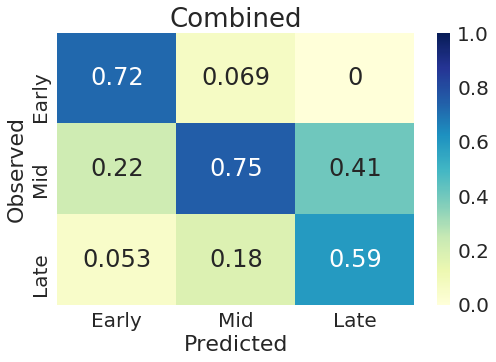

Precision : 0.689144736842
Classification 
             precision    recall  f1-score   support

          0       0.72      0.87      0.79        63
          1       0.75      0.74      0.75       117
          2       0.59      0.43      0.50        44

avg / total       0.71      0.72      0.71       224



In [65]:
all_y=np.concatenate(all_y)
all_preds=np.concatenate(all_preds)
conf_matrix = confusion_matrix(all_y, all_preds)
# try different plots of the confusion matrix
norm_matrix = conf_matrix/conf_matrix.sum(axis=0, keepdims=True)
plt.figure(figsize=(8,5))
sns.heatmap(norm_matrix, annot=True, 
            xticklabels=['Early', 'Mid', 'Late'],
           yticklabels = ['Early', 'Mid', 'Late'], cmap="YlGnBu",
           vmin=0, vmax=1)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('Combined', fontsize=26)
plt.show()

print('Precision :', precision_score(all_y, all_preds, average = 'macro'))
print('Classification ' + '\n'+ classification_report(all_y, all_preds))